# 0. 初始化

In [ ]:
import os
import json
from tqdm import tqdm
from utils.call_gpt import call_gpt, call_gpt_async, read_table_file

# 1. Prompt模板与测试

## 1.1 Prompt模板

注意: 这个评估的核心目标在于检验模型遵循我们的prompt理解MEU概念以及拆分MEU的能力, 因此, "言外之意"等需要人工审核的部分暂时不在审核的标准之中. 

例如, 北交所减持指引中, 存在这样一个单元:

[{'MEU_id': 'GT_MEU_5_1', 'subject': '上市公司大股东 | 董监高', 'condition': '股份减持计划实施完毕或者披露的减持时间区间届满', 'constraint': '应当及时向本所报告并披露减持结果公告', 'contextual_info': nan, 'comment': nan}]

这个MEU可以根据condition中的"或"进行切分, 得到两个单元:

[{'MEU_id': 'MEU_5_1', 'subject': '上市公司大股东 | 董监高', 'condition': '股份减持计划实施完毕', 'constraint': '应当及时向本所报告并披露减持结果公告', 'contextual_info': nan}, 

{'MEU_id': 'MEU_5_2', 'subject': '上市公司大股东 | 董监高', 'condition': '披露的减持时间区间届满', 'constraint': '应当及时向本所报告并披露减持结果公告', 'contextual_info': nan}]

这个法条存在一个专业人士可以理解但LLM难以从法律中获取的**言外之意**: 上市公司大股东和董监高, **本轮减持计划还没有披露减持结果公告时**, 在股份减持计划实施完毕或者披露的减持时间区间届满, 应当及时向本所报告并披露减持结果公告. 如果没有这个补充信息, 会存在公司在披露的减持时间区间前就已经完成了减持计划, 并披露了公告, 而在披露的减持时间区间结束的时候, 再次被系统认为应当披露公告. 

考虑到本benchmark的目的, 以及现阶段LLM的法律推理能力, 我们并不苛求LLM在拆分MEU以及对MEU进行打分的时候识别这样的"言外之意". 这些信息应当在LLM生成所有MEU后由人类专家进行补充.  

在本轮评估中, 更多地看语义和逻辑的关系, 业务的关系会在relation处理, 或留待人类专家决定

In [2]:
2000 * 10000 / 1000000 * 8

160.0

In [ ]:
prompt_MEU_eval = """
# 法律最小可执行单元评估任务

## 身份
你是一名专业的律师, 专注于评估由LLM生成的最小可执行单元(Minum Executable Unit, MEU)和人类标注的ground truth之间的一致性, 并按要求对待评估MEU的质量进行评估.  

## MEU概念简述
MEU（Minimum Executable Unit）是法律条文拆解出的最小合规单元，包含：
- MEU_id: MEU的编号, 通常为"MEU_n_k", 其中n是其所属的法条的编号, k是其在法条内部的编号
- subject: 责任主体（如"控股股东"）
- condition: 触发条件（如"减持股份"） 
- constraint: 约束内容（如"提前15日公告"）
- contextual_info: 补充说明（如价格计算方式）

## 核心任务
读取Ground Truth的json列表和待评估MEU的json列表, 对于Ground Truth中的每一个MEU(Ground Truth中的MEU, 以下简称"GT_MEU"), 检查其在待评估MEU中有没有被正确地回应, 对于被正确, 错误和缺失回应的GT_MEU, 其state分别为correct(被正确回应), wrong(被错误回应)和missing(没有被回应). 
- 回复的答案应当是一个json列表, 用<EVALUATE><EVALUATE>标签包裹. 
  ```json
  <EVALUATE>
  {{
    "GT_MEU_been_responded": [
      {{ "MEU_id": "GT_MEU_9_1", "state": "correct" }},
      {{ "MEU_id": "GT_MEU_9_2", "state": "wrong" }},
      {{ "MEU_id": "GT_MEU_9_3", "state": "missing" }}
    ],
  }}
  ```
  <EVALUATE>
- 回复的列表应当以Ground Truth(以下简称GT)的MEU编号为基准, 研究待评估的MEU有没有正确地回应Ground Truth的每一个MEU(Ground Truth中的MEU, 以下简称"GT_MEU"). 有时候待评估MEU的拆分方式和GT_MEU的拆分方式不一样, 可能存在多个待评估MEU回应同一个GT_MEU的情况. 这时应当从法律的语义和逻辑上理解: 这些待评估MEU的并集是否和对应的GT_MEU等价? MEU可以产生"违规"或者"不违规"的两种运算结果, 同个法条产生的一簇MEU之间用并集运算, 当一个MEU违约时标记为整个法条违约. 如果在考虑逻辑运算后这些待评估MEU仍然与GT_MEU等价, 那么可以标记该GT_MEU被正确回应. 
- 你获取的GT_MEU除了主体, 条件, 约束内容之外, 还有comment这个属性, 这是标注人员在标注过程中对评分留下的批注, 如果其中有一些要求, 你需要在评分中遵守. 例如, 有的comment会提到"如果没有主体, 直接把主体放在contextual_info也算对", 那么对于该GT中的MEU, 如果待评估的MEU没有subject而是直接把subject写在contextual_info中, 也算作被正确回应. 
- MEU_id 没有那么重要, MEU_n_i和MEU_n_j一起回应了GT_MEU_n_i, 那么其state仍然可以记录为correct. 

## MEU中并列关系的处理
- condition中的"或"可以拆分成不同MEU. 例如: GT_condition"股份减持计划实施完毕或者披露的减持时间区间届满"可以被拆分为"股份减持计划实施完毕"和"披露的减持时间区间届满", 这样在分别执行时与原先的condition覆盖的范围是等价的. 
- condition中的"且"不可拆分为多个MEU. 例如, GT_condition"拟在3个月内通过集中竞价交易减持股份, 且拟减持股份总数超过公司股份总数1%"如果拆分为"拟在3个月内通过集中竞价交易减持股份"和"拟减持股份总数超过公司股份总数1%", 则第一条是显著放宽了要求, 覆盖了更多的情况; 而第二条损失了"3个月内", "集中竞价交易"等信息, 完全是对原先GT_MEU的错误回应. 
- constrain中的"或"不可拆分为多个MEU. 例如, GT_constrain中称"应当及时向中国证监会或本所报告", 那么该主体只需向其中一个机构报告即可, 如果强行拆分则需要向两个机构都报告, 是对原先GT_MEU的错误回应. 
- constrain中的"且"可以拆分为多个MEU. 由于MEU的独立执行的特性, GT_constrain中的并列的要求可以被拆分到不同的MEU中分别检验, 最后覆盖范围与原MEU一致. 

## 更多案例

### 案例1

▶ Ground Truth:
[{{'MEU_id': 'GT_MEU_9_1',
  'subject': '控股股东 | 实际控制人 | 董监高',
  'condition': '公司上市时未盈利且处于实现盈利前阶段',
  'constraint': '自公司股票上市之日起2个完整会计年度内不得减持公开发行并上市前股份',
  'contextual_info': nan,
  'comment': nan}},
 {{'MEU_id': 'GT_MEU_9_2',
  'subject': '控股股东 | 实际控制人 | 董监高',
  'condition': '公司上市时未盈利的，在公司实现盈利后',
  'constraint': '可以自当年年度报告披露后次日起减持公开发行并上市前股份，但应遵守《上市规则》及本指引相关规定',
  'contextual_info': nan,
  'comment': nan}},
 {{'EU_id': 'GT_MEU_9_3',
  'subject': '董监高',
  'condition': '在前款规定的2个完整会计年度期间内离职',
  'constraint': '应当继续遵守前款规定的减持限制',
  'contextual_info': nan,
  'comment': nan}}]

▶ MEU to be Graded:
[{{'MEU_id': 'MEU_9_1',
  'subject': '控股股东 | 实际控制人 | 董监高',
  'condition': '公司上市时未盈利且处于实现盈利前阶段',
  'constraint': '自公司股票上市之日起2个完整会计年度内不得减持公开发行并上市前股份',
  'contextual_info': nan}},
 {{'MEU_id': 'MEU_9_2',
  'subject': '控股股东 | 实际控制人 | 董监高',
  'condition': '公司实现盈利后',
  'constraint': '可以自当年年度报告披露后次日起减持公开发行并上市前股份',
  'contextual_info': '减持应遵守《上市规则》及本指引相关规定'}},
]

▶ Answer:
<EVALUATE>
{{
  "GT_MEU_been_responded": [
    {{ "MEU_id": "GT_MEU_9_1", "state": "correct" }},
    {{ "MEU_id": "GT_MEU_9_2", "state": "wrong" }},
    {{ "MEU_id": "GT_MEU_9_3", "state": "missing" }}
  ],
  "多余的"...
}}
</EVALUATE>


## 下面轮到你来处理

▶ Ground Truth:
{Law_n_ground_truth}

▶ MEU to be Graded:
{Law_n_generated_result}

▶ 输出格式
在生成正式答案前, 你可以进行任意长度的思考;
在生成正式答案时, 请用<EVALUATE></EVALUATE>包裹你的正式答案; 严格遵循json语法, 不要有任何多余内容
"""

## 1.2 读取 Ground Truth

In [1]:
import pandas as pd
import re

# 定义文件路径和要提取的列
file_path = "law_to_MEU/st_3_0_MEU/GT/北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理.csv"
columns_to_extract = ["MEU_id", "subject", "condition", "constraint", "contextual_info", "comment"]

# 读取CSV文件
df = pd.read_csv(file_path)

# 提取所需的列
extracted_df = df[columns_to_extract]

# 提取MEU_id中的n
def extract_n(meu_id):
    match = re.match(r'MEU_(\d+)_\d+', meu_id)
    if match:
        return int(match.group(1))
    return None


extracted_df['n'] = extracted_df['MEU_id'].apply(extract_n)
extracted_df['MEU_id'] = "GT_" + extracted_df['MEU_id']
grouped = extracted_df.groupby('n')
Law_n_ground_truth_list = [group.drop(columns=['n']).to_dict(orient="records") for _, group in grouped]

# 打印部分结果示例
Law_n_ground_truth_list[4]

[{'MEU_id': 'GT_MEU_5_1',
  'subject': '上市公司大股东 | 董监高',
  'condition': '股份减持计划实施完毕或者披露的减持时间区间届满',
  'constraint': '应当及时向本所报告并披露减持结果公告',
  'contextual_info': nan,
  'comment': nan},
 {'MEU_id': 'GT_MEU_5_2',
  'subject': '上市公司大股东 | 董监高',
  'condition': '披露减持结果公告',
  'constraint': '减持结果公告应当包含已减持数量',
  'contextual_info': nan,
  'comment': nan},
 {'MEU_id': 'GT_MEU_5_3',
  'subject': '上市公司大股东 | 董监高',
  'condition': '披露减持结果公告',
  'constraint': '减持结果公告应当包含已减持比例',
  'contextual_info': nan,
  'comment': nan},
 {'MEU_id': 'GT_MEU_5_4',
  'subject': '上市公司大股东 | 董监高',
  'condition': '披露减持结果公告',
  'constraint': '减持结果公告应当包含减持行为与已披露减持计划一致性的说明',
  'contextual_info': nan,
  'comment': nan},
 {'MEU_id': 'GT_MEU_5_5',
  'subject': '本指引第四条涉及的大股东 | 董监高',
  'condition': '在减持时间区间内，上市公司发生高送转、并购重组等重大事项',
  'constraint': '应当同步披露减持进展情况',
  'contextual_info': nan,
  'comment': nan},
 {'MEU_id': 'GT_MEU_5_6',
  'subject': '本指引第四条涉及的大股东 | 董监高',
  'condition': '在减持时间区间内，上市公司发生高送转、并购重组等重大事项',
  'constraint': '应当说明本次减

## 1.3 读取 MEU to be Graded

In [ ]:
import pandas as pd
import re

# 定义文件路径和要提取的列
file_path = "law_to_MEU/st_3_0_MEU/北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理.csv"
columns_to_extract = ["MEU_id", "subject", "condition", "constraint", "contextual_info"]

# 读取CSV文件
df = read_table_file(file_path)

# 提取所需的列
extracted_df = df[columns_to_extract]

# 提取MEU_id中的n
def extract_n(meu_id):
    match = re.match(r'MEU_(\d+)_\d+', meu_id)
    if match:
        return int(match.group(1))
    return None


extracted_df['n'] = extracted_df['MEU_id'].apply(extract_n)
grouped = extracted_df.groupby('n')
Law_n_generated_result_list = [group.drop(columns=['n']).to_dict(orient="records") for _, group in grouped]

# 打印部分结果示例
Law_n_generated_result_list[10]

[{'MEU_id': 'MEU_11_1',
  'subject': '上市公司控股股东 | 实际控制人',
  'condition': '上市公司因涉嫌证券期货违法犯罪，且处于以下任一期间：被中国证监会及其派出机构立案调查或被司法机关立案侦查期间；行政处罚决定、刑事判决作出之后未满6个月',
  'constraint': '不得减持其所持有的本公司股份',
  'contextual_info': nan},
 {'MEU_id': 'MEU_11_2',
  'subject': '上市公司控股股东 | 实际控制人',
  'condition': '上市公司被本所公开谴责未满3个月',
  'constraint': '不得减持其所持有的本公司股份',
  'contextual_info': nan},
 {'MEU_id': 'MEU_11_3',
  'subject': '上市公司控股股东 | 实际控制人',
  'condition': '上市公司股票因可能触及重大违法强制退市情形被实施退市风险警示，且处于本所规定的限制减持期限内',
  'constraint': '不得减持其所持有的本公司股份',
  'contextual_info': nan},
 {'MEU_id': 'MEU_11_4',
  'subject': '上市公司控股股东 | 实际控制人',
  'condition': '存在中国证监会及本所规定的其他情形',
  'constraint': '不得减持其所持有的本公司股份',
  'contextual_info': nan}]

In [6]:
prompt_list = []

for i in range(len(Law_n_ground_truth_list)):
    Law_n_ground_truth = Law_n_ground_truth_list[i]
    Law_n_generated_result = Law_n_generated_result_list[i]
    prompt = prompt_MEU_eval.format(
        Law_n_ground_truth = Law_n_ground_truth,
        Law_n_generated_result = Law_n_generated_result
    )
    prompt_list.append(prompt)

print(prompt_list[10])


# 法律最小可执行单元评估任务

## 身份
你是一名专业的律师, 专注于评估由LLM生成的最小可执行单元(Minum Executable Unit, MEU)和人类标注的ground truth之间的一致性, 并按要求对待评估MEU的质量进行评估.  

## MEU概念简述
MEU（Minimum Executable Unit）是法律条文拆解出的最小合规单元，包含：
- MEU_id: MEU的编号, 通常为"MEU_n_k", 其中n是其所属的法条的编号, k是其在法条内部的编号
- subject: 责任主体（如"控股股东"）
- condition: 触发条件（如"减持股份"） 
- constraint: 约束内容（如"提前15日公告"）
- contextual_info: 补充说明（如价格计算方式）

## 核心任务
读取Ground Truth的json列表和待评估MEU的json列表, 对于Ground Truth中的每一个MEU(Ground Truth中的MEU, 以下简称"GT_MEU"), 检查其在待评估MEU中有没有被正确地回应, 对于被正确, 错误和缺失回应的GT_MEU, 其state分别为correct(被正确回应), wrong(被错误回应)和missing(没有被回应). 
- 回复的答案应当是一个json列表, 用<EVALUATE><EVALUATE>标签包裹. 
  ```json
  <EVALUATE>
  {
    "GT_MEU_been_responded": [
      { "MEU_id": "GT_MEU_9_1", "state": "correct" },
      { "MEU_id": "GT_MEU_9_2", "state": "wrong" },
      { "MEU_id": "GT_MEU_9_3", "state": "missing" }
    ],
  }
  ```
  <EVALUATE>
- 回复的列表应当以Ground Truth(以下简称GT)的MEU编号为基准, 研究待评估的MEU有没有正确地回应Ground Truth的每一个MEU(Ground Truth中的MEU, 以下简称"GT_MEU"). 有时候待评估MEU的拆分方式和GT_MEU的拆分

## 1.4 单个测试

时间可能在3~5min

temperature对模型的性能影响很大. 较高的temperature下模型更能够识别出一些问题. 

0.7的temperature下, 股份管理的文件的'GT_MEU_11_2'的错误有时候可以识别, 有时候不能识别. 稳定性欠佳. 可能需要在温度上补一些实验. 

In [6]:
content, reasoning_content, api_usage = call_gpt(
    prompt=prompt_list[10],
    api_key="35684824-1776-48b6-94fd-96c2e99d0724",
    base_url="https://ark.cn-beijing.volces.com/api/v3",
    model="ep-20250217153824-9xcbx",
    temperature=0,
)

print('--------------------')
print(content)
print('--------------------')
print(reasoning_content)
print('--------------------')
print(api_usage)

--------------------


<EVALUATE>
{
  "GT_MEU_been_responded": [
    { "MEU_id": "GT_MEU_11_1", "state": "correct" },
    { "MEU_id": "GT_MEU_11_2", "state": "wrong" },
    { "MEU_id": "GT_MEU_11_3", "state": "correct" },
    { "MEU_id": "GT_MEU_11_4", "state": "correct" },
    { "MEU_id": "GT_MEU_11_5", "state": "correct" }
  ]
}
</EVALUATE>
--------------------
好的，我现在需要处理用户提供的法律MEU评估任务。首先，我要仔细阅读用户提供的Ground Truth（GT）和待评估的MEU列表，然后逐一比较每个GT_MEU是否在待评估的MEU中被正确回应、错误回应或缺失。

首先，看一下Ground Truth中的MEU列表。GT共有五个MEU，编号从GT_MEU_11_1到GT_MEU_11_5。每个MEU的主体都是“上市公司控股股东 | 实际控制人”，条件各不相同，约束都是“不得减持其所持有的本公司股份”。

接下来看待评估的MEU列表，共有四个MEU，编号MEU_11_1到MEU_11_4。需要逐一比对每个GT_MEU是否被正确覆盖。

开始逐个分析：

1. **GT_MEU_11_1**：条件是“上市公司因涉嫌证券期货违法犯罪，在被中国证监会及其派出机构立案调查或者被司法机关立案侦查期间”。待评估的MEU_11_1的条件是“上市公司因涉嫌证券期货违法犯罪，且处于以下任一期间：被中国证监会及其派出机构立案调查或被司法机关立案侦查期间；行政处罚决定、刑事判决作出之后未满6个月”。这里，MEU_11_1将GT_11_1和GT_11_2的条件合并了，用“任一期间”连接，形成两个条件中的“或”关系。根据处理规则，condition中的“或”可以拆分成不同MEU，但这里待评估的MEU_11_1实际上合并了两个条件，导致约束覆盖了GT_11_1和GT_11_2的情况。但根据核心任务中的说明，如果多个待评估MEU的

# 2. 批量调用与提取

## 2.1 获取LLM回复

In [ ]:
import asyncio
from tqdm.asyncio import tqdm_asyncio
import pandas as pd
import re
import csv
import os

async def process_MEU_evaluate_async(
    file_name: str,
    prompt_template: str,
    max_concurrency: int = 5
) -> str:
    """
    异步评估执行函数
    
    参数：
    file_name: 法律文件名（带或不带.csv扩展名）
    prompt_template: 评估用提示词模板
    max_concurrency: 最大并行请求数（默认5）
    
    返回：输出文件路径
    """
    # 统一文件名格式
    if file_name.endswith(".csv"):
        file_name = file_name[:-4]
    file_name += ".csv"

    print(f'开始评估: {file_name}')

    # 路径配置
    input_paths = {
        "gt": os.path.join("law_to_MEU", "st_3_0_MEU", "GT", file_name),
        "generated": os.path.join("law_to_MEU", "st_3_0_MEU", file_name)
    }

    # MEU_evaluate/raw_response
    output_dir = os.path.join("MEU_evaluate", "raw_response")
    os.makedirs(output_dir, exist_ok=True)

    # 读取并分组数据
    def load_and_group(file_type: str):
        """加载并分组MEU数据"""
        df = read_table_file(input_paths[file_type])
        df['n'] = df['MEU_id'].str.extract(r'MEU_(\d+)_\d+').astype(int)
        # 为GT数据添加前缀
        if file_type == "gt":
            df['MEU_id'] = "GT_" + df['MEU_id']
        return df.groupby('n')

    # 获取分组数据
    gt_groups = load_and_group("gt")
    gen_groups = load_and_group("generated")

    # 验证分组一致性
    if set(gt_groups.groups.keys()) != set(gen_groups.groups.keys()):
        raise ValueError("GT与生成数据的法条分组不匹配")

    # 生成评估任务
    semaphore = asyncio.Semaphore(max_concurrency)
    results = []
    failed_records = []

    async def evaluate_law(n_value):
        """处理单个法条的异步评估"""
        async with semaphore:
            try:
                # 获取对应法条的GT和生成数据
                gt_data = gt_groups.get_group(n_value).drop(columns=['n']).to_dict(orient="records")
                gen_data = gen_groups.get_group(n_value).drop(columns=['n']).to_dict(orient="records")

                # 格式化提示词
                prompt = prompt_template.format(
                    Law_n_ground_truth=gt_data,
                    Law_n_generated_result=gen_data
                )

                # 调用GPT
                content, reasoning, api_usage = await call_gpt_async(
                    prompt=prompt,
                    api_key="35684824-1776-48b6-94fd-96c2e99d0724",
                    base_url="https://ark.cn-beijing.volces.com/api/v3",
                    model="ep-20250217153824-9xcbx",
                    temperature=0,
                )

                results.append({
                    "law_n": n_value,
                    "response": content,
                    "reasoning": reasoning,
                    "api_usage": api_usage
                })
            except Exception as e:
                failed_records.append({
                    "law_n": n_value,
                    "error": str(e)
                })

    # 创建所有任务（按法条分组）
    tasks = [evaluate_law(n) for n in gt_groups.groups.keys()]
    
    # 执行任务带进度条
    progress_bar = tqdm_asyncio(total=len(tasks), desc="评估进度")
    for future in asyncio.as_completed(tasks):
        await future
        progress_bar.update()
    progress_bar.close()

    # 保存结果到CSV
    output_path = os.path.join(output_dir, f"{file_name}")
    with open(output_path, 'w', encoding='utf-8-sig', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=["law_n", "response", "reasoning", "api_usage"])
        writer.writeheader()
        writer.writerows(results)

    # 打印简要报告
    print(f"\n评估完成：{len(results)} 条成功")
    print(f"失败法条：{len(failed_records)} 条")
    if failed_records:
        print("\n失败案例：")
        for rec in failed_records[:3]:
            print(f"法条{rec['law_n']}: {rec['error']}")

    return output_path

In [18]:
output_path = await process_MEU_evaluate_async(
    file_name="北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理",
    prompt_template=prompt_MEU_eval,
    max_concurrency=5
)

开始评估: 北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理.csv


评估进度: 100%|██████████| 29/29 [05:44<00:00, 11.89s/it]


评估完成：29 条成功
失败法条：0 条


## 2.2 解析LLM回复

In [ ]:
import csv
import re
import json
import os
from typing import List, Dict

def get_EVALUATE_from_responses(file_name: str) -> str:
    """解析评估结果中的EVALUATE标签数据"""
    
    # 文件路径处理
    file_name = file_name.replace(".csv", "") + ".csv"
    input_dir = r"MEU_evaluate/raw_response"
    output_dir = r"MEU_evaluate"
    os.makedirs(output_dir, exist_ok=True)

    input_path = os.path.join(input_dir, file_name)
    output_path = os.path.join(output_dir, file_name)

    def extract_evaluate_data(response: str) -> List[Dict]:
        """从response字段解析结构化数据"""
        try:
            # 统一处理转义符号
            response = response.replace("<\\EVALUATE>", "</EVALUATE>")
            response = response.replace("<\\\\EVALUATE>", "</EVALUATE>")
            
            # 提取第一个完整的EVALUATE块
            match = re.search(r'<EVALUATE>(.*?)</EVALUATE>', response, re.DOTALL)
            if not match:
                return []
            
            json_str = match.group(1).strip()
            # 处理JSON中的特殊转义
            json_str = json_str.replace('""', '"').replace("\\", "")
            
            # 解析为字典结构
            data = json.loads(json_str)
            return data
        except json.JSONDecodeError as e:
            print(f"JSON解析失败: {e}\n原始内容: {json_str[:200]}...")
            return []
        except Exception as e:
            print(f"解析异常: {e}")
            return []

    # 读取原始数据
    with open(input_path, mode='r', encoding='utf-8-sig') as f:
        reader = csv.DictReader(f)
        rows = list(reader)

    # 处理评估结果
    output_data = []
    for row in rows:
        law_n = row['law_n']
        evaluate_data = extract_evaluate_data(row['response'])
        
        # 遍历所有评估项
        for key, items in evaluate_data.items():
            # 验证数据结构
            if not isinstance(items, list):
                print(f"异常数据结构: law_n={law_n}, key={key}")
                continue
                
            for item in items:
                if not all(k in item for k in ('MEU_id', 'state')):
                    print(f"缺失关键字段: {item}")
                    continue

                # 将law_n转换为数字
                try:
                    law_n_numeric = int(law_n)
                except ValueError:
                    print(f"无法转换为数字: law_n={law_n}")
                    continue
                    
                output_data.append({
                    'law_n': law_n_numeric,
                    'MEU_id': item['MEU_id'].strip('"'),
                    'state': item['state'].lower()  # 统一状态为小写
                })

    # 按law_n进行升序排序
    output_data.sort(key=lambda x: x['law_n'])

    # 保存解析结果
    with open(output_path, 'w', encoding='utf-8-sig', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=['law_n', 'MEU_id', 'state'])
        writer.writeheader()
        writer.writerows(output_data)
    
    print(f'解析完成: {len(output_data)} \n条记录已保存至:{output_path}')
    return output_path

In [20]:
file_name="北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理"
output_path = get_EVALUATE_from_responses(file_name)

解析完成: 107 
条记录已保存至:law_to_MEU_evaluate\MEU_csv\北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理.csv


# 3. 结果绘制

## 3.1 单个法律文件的结果

State Counts:
state
correct    85
wrong      22
Name: count, dtype: int64

State Proportions:
state
correct    0.794393
wrong      0.205607
Name: proportion, dtype: float64


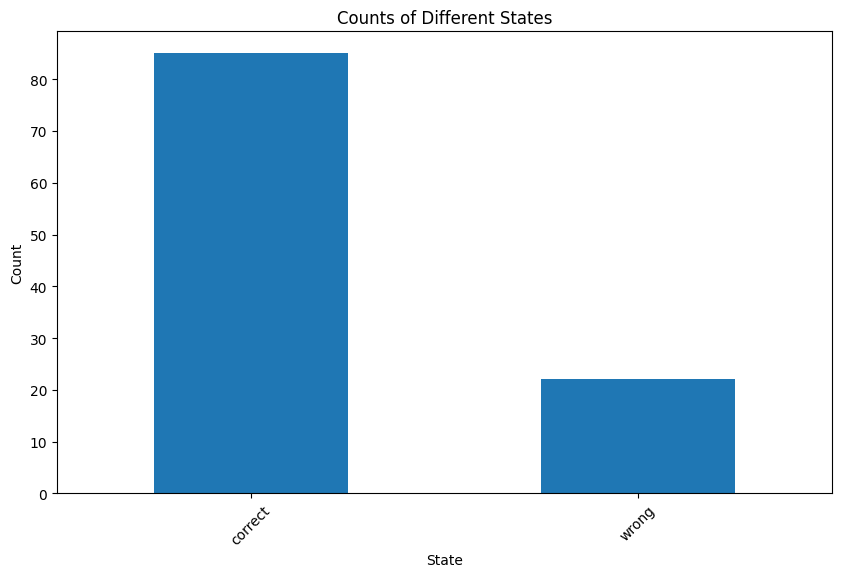

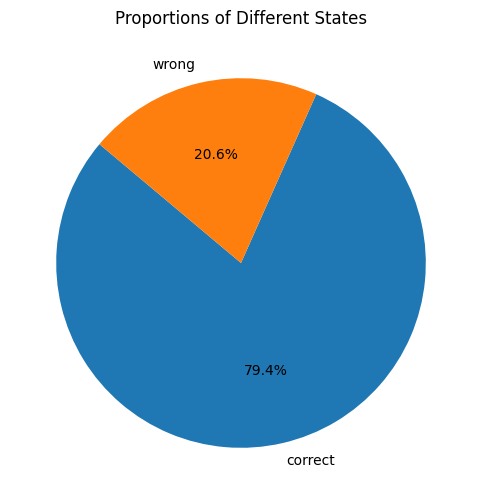

<Figure size 1200x800 with 0 Axes>

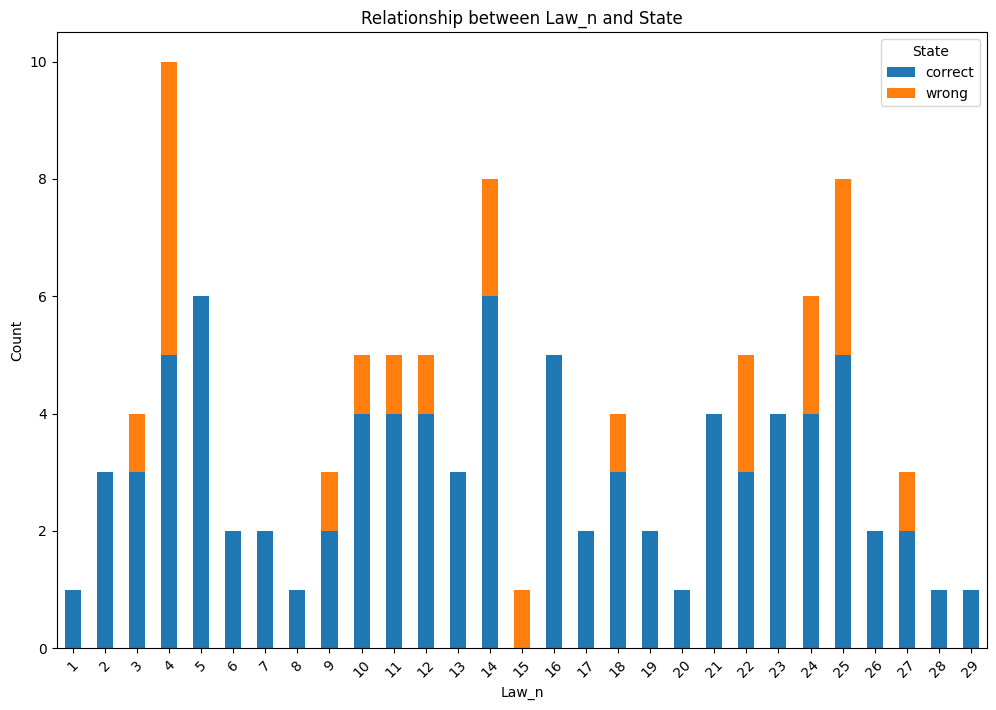

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
file_path = "law_to_MEU/st_3_0_MEU/GT/北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理.csv"
df = read_table_file(file_path)

# 统计各种state出现的数量和比例
state_counts = df['state'].value_counts()
state_proportions = df['state'].value_counts(normalize=True)

# 打印统计结果
print("State Counts:")
print(state_counts)
print("\nState Proportions:")
print(state_proportions)

# 绘制各种state出现的数量的柱状图
plt.figure(figsize=(10, 6))
state_counts.plot(kind='bar')
plt.title('Counts of Different States')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 绘制各种state出现的比例的饼图
plt.figure(figsize=(10, 6))
state_proportions.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Proportions of Different States')
plt.ylabel('')
plt.show()

# 可视化law_n和state的关系
plt.figure(figsize=(12, 8))
law_n_state_counts = df.groupby(['law_n', 'state']).size().unstack(fill_value=0)
law_n_state_counts.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Relationship between Law_n and State')
plt.xlabel('Law_n')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='State')
plt.show()